In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from pedalboard.pedalboard import load_plugin

from src.dataset.paired_audio_dataset import PairedAudioDataset
from src.wrappers.dafx_wrapper import DAFXWrapper

from src.models.style_transfer_vae import StyleTransferVAE

In [2]:
DAFX_TO_USE = [
    'mda Overdrive',
    'mda Delay'
]

In [3]:
DAFX_FILE = "/home/kieran/Level5ProjectAudioVAE/src/dafx/mda.vst3"
SAMPLE_RATE = 24_000
AUDIO_DIR = "/home/kieran/Level5ProjectAudioVAE/src/audio"
DATASETS = ["vctk_24000"]
NUM_EXAMPLES = 2_000
CHECKPOINT = "/home/kieran/Level5ProjectAudioVAE/src/l5proj_style_vae/ync68xdq/checkpoints/epoch=193-step=121250.ckpt"
CHECKPOINT_ID = CHECKPOINT.split("/")[-3]


In [4]:
def dafx_from_name(dafx_name):
    dafx = load_plugin(DAFX_FILE, plugin_name=dafx_name)
    return DAFXWrapper(dafx=dafx, sample_rate=SAMPLE_RATE)

In [5]:
def get_dataset(dafx):
    dataset = PairedAudioDataset(
        dafx=dafx,
        audio_dir=AUDIO_DIR,
        subset="train",
        input_dirs=DATASETS,
        num_examples_per_epoch=NUM_EXAMPLES,
        augmentations={},
        length=131_072,
        effect_input=False,
        effect_output=True,
        dummy_setting=True
    )

    return torch.utils.data.DataLoader(
        dataset,
        num_workers=4,
        batch_size=1,
        timeout=6000,
    )

In [6]:
latent_embeddings = dict()

In [7]:
model = StyleTransferVAE.load_from_checkpoint(CHECKPOINT)
model.eval()

StyleTransferVAE(
  (encoder_conv): Sequential(
    (0): Sequential(
      (0): Conv2d(2, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (mu): Linear(in_features=20640, out_features=2048, bias=True)
  (log_var): Linear(in_features=2064

In [8]:
from tqdm import tqdm

mu_running = []
log_var_running = []

for fx in DAFX_TO_USE:
    dafx = dafx_from_name(fx)
    dataset = get_dataset(dafx)

    embeddings = []

    for batch in tqdm(dataset):
        x, y = batch
        x_s = model.audio_to_spectrogram(signal=x, return_phase=False)
        y_s = model.audio_to_spectrogram(signal=y, return_phase=False)

        X = torch.concat([x_s, y_s], dim=1)

        x_hat, mu, log_var, z = model(X)

        embeddings.append(z.detach().numpy())
        mu_running.append(mu.detach().numpy())
        log_var_running.append(log_var.detach().numpy())

    latent_embeddings[fx] = np.array(embeddings)

100%|████████████████████████████████████████| 88/88 [00:00<00:00, 36726.24it/s]



Loaded 88 files for train = 66.89 hours.


100%|████████████████████████████████████████| 88/88 [00:00<00:00, 43561.76it/s]



Loaded 88 files for train = 66.89 hours.


100%|██████████| 2000/2000 [00:50<00:00, 39.43it/s]


In [19]:
def kl_loss(mean, log_variance):
    kld_batch = -0.5 * torch.sum(1 + log_variance - torch.square(mean) - torch.exp(log_variance))
    kld = kld_batch / (mean.size()[0] * mean.size()[1])
    return kld

In [20]:
log_var_tensor = torch.tensor(np.array(log_var_running)).squeeze()

In [21]:
mu_tensor = torch.tensor(np.array(mu_running)).squeeze()

In [22]:
kl_loss(mu_tensor, log_var_tensor)

tensor(4.1497)

In [13]:
data = np.concatenate([v for v in latent_embeddings.values()]).squeeze()

In [14]:
import umap

In [15]:
reducer = umap.UMAP().fit(data)

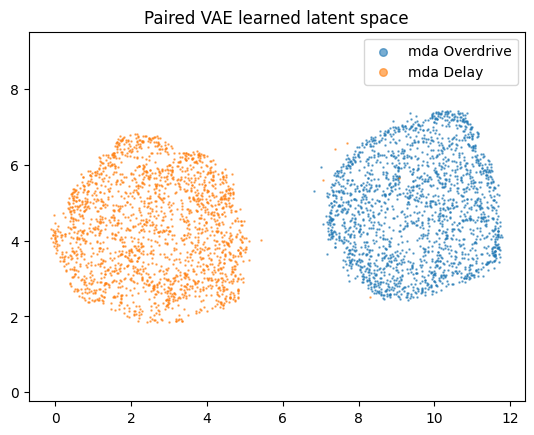

In [16]:
for fx, X in latent_embeddings.items():
    embeds = reducer.transform(X.squeeze())
    plt.scatter(x=embeds[:,0], y=embeds[:,1], label=fx, alpha=0.6, s=0.6)

plt.gca().set_aspect('equal', 'datalim')
plt.title(f"Paired VAE learned latent space")

lgnd = plt.legend()
for i in range(len(latent_embeddings.keys())):
    lgnd.legendHandles[i]._sizes = [30]

plt.savefig(f"./figures/{CHECKPOINT_ID}_latent_spectrogram_embeddings.svg")